# Best Model Evaluation

In [1]:
!python evaluate.py --niters 1 --batch-size 20 --dataset sgra --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id final

evaluate.py --niters 1 --batch-size 20 --dataset sgra --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id final
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the l

In [8]:
!python test_prediction.py --batch-size 260 --dataset sgra --norm --shuffle --sample-tp 0.1 --mse-weight 1.0 --imab-dim 128 --cab-dim 256 --decoder-dim 128 --nlayers 1 --sample-type random --num-ref-points 128 --experiment-id final --plot-sample 150

test_prediction.py --batch-size 260 --dataset sgra --norm --shuffle --sample-tp 0.1 --mse-weight 1.0 --imab-dim 128 --cab-dim 256 --decoder-dim 128 --nlayers 1 --sample-type random --num-ref-points 128 --experiment-id final --plot-sample 150
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
test_prediction.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start

/tmp/ipykernel_46233/3595289197.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chp = torch.load(model_path, map_location=device)  # Load the model


MSE for key X is: 0.91325
MSE for key NIR is: 0.93829
MSE for key IR is: 0.36798
MSE for key Sub-mm is: 414.99045
Results saved to real_results.npz


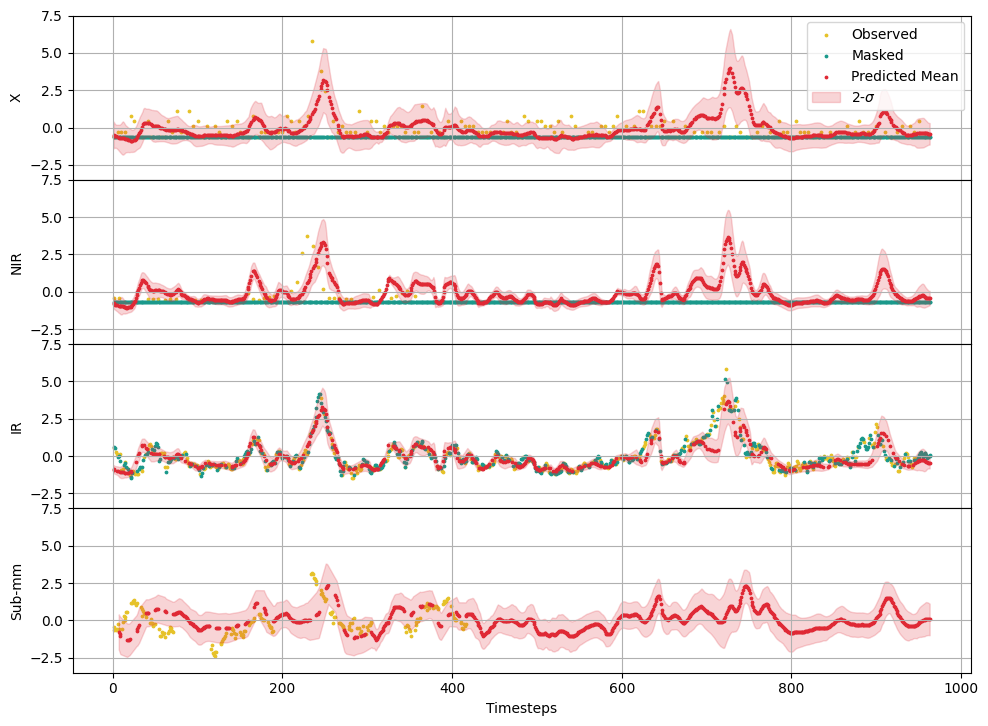

In [2]:
import argparse
import numpy as np
import torch
import models
import utils
import matplotlib.pyplot as plt

def plot_tripletformer_on_real_data(real_data, keys, model_path, save_path="real_results.npz"):
    """
    Evaluates the Tripletformer model on real data and saves the results.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dim = len(keys)

    # Create a dummy argparse namespace to load the model
    class DummyArgs:
        def __init__(self):
            self.dataset = 'sgra'  # Assuming 'sgra' dataset configuration
            self.experiment_id = model_path.split('_')[-1].split('.')[0]
            self.net = 'triple'
            self.imab_dim = 128
            self.cab_dim = 256
            self.decoder_dim = 128
            self.nlayers = 1
            self.enc_num_heads = 4
            self.dec_num_heads = 4
            self.num_ref_points = 128 #added this line
            self.mse_weight = 1.0 #added this line
            self.norm = True #added this line
            self.sample_tp = 0.1 #added this line
            self.sample_type = 'random' #added this line

    args = DummyArgs()

    net = models.load_network(args, dim, device=device).to(device)
    chp = torch.load(model_path, map_location=device)  # Load the model
    net.load_state_dict(chp['state_dict'])

    net.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        real_data_tensor = torch.tensor(real_data, dtype=torch.float32).to(device)

        # Create context and reconstruction masks
        original_mask = torch.ones(real_data_tensor[:, :, dim:2 * dim].shape).to(device)
        subsampled_mask = real_data_tensor[:, :, dim:2 * dim]
        recon_mask = original_mask - subsampled_mask
        context_y = torch.cat((real_data_tensor[:, :, :dim] * subsampled_mask, subsampled_mask), -1)

        # Compute predictions
        px, time_indices, channel_indices = net.inference(
            real_data_tensor[:, :, -1],  # Time progression indicator
            context_y,
            real_data_tensor[:, :, -1],
            torch.cat((real_data_tensor[:, :, :dim] * recon_mask, recon_mask), -1)
        )

        means = px.mean
        logvars = px.logvar
        std = torch.sqrt(torch.exp(logvars))

        # Move everything to CPU for processing
        means = means.squeeze().cpu().numpy()
        stds = std.squeeze().cpu().numpy()
        time_indices = time_indices.squeeze().cpu().numpy()
        channel_indices = channel_indices.squeeze().cpu().numpy()
        real_data_numpy = real_data_tensor[:, :, :-1].squeeze().cpu().numpy()

        # Save data
        saved_data = {}

        # Create subplots
        fig, axs = plt.subplots(dim, 1, figsize=(10, 2 * dim), sharex=True, gridspec_kw={'hspace': 0})
        timesteps = np.arange(1, real_data_numpy.shape[0] + 1)

        if dim == 1:
            axs = [axs]

        for chan in range(dim):
            ax = axs[chan]

            # Observed values
            obs_indices = np.where(real_data_numpy[:, chan + dim] == 1)
            obs_x = timesteps[obs_indices]
            obs_y = real_data_numpy[:, chan][obs_indices]

            # Masked values
            masked_indices = np.where(real_data_numpy[:, chan + dim] == 0)
            masked_x = timesteps[masked_indices]
            masked_y = real_data_numpy[:, chan][masked_indices]

            # Predictions
            pred_indices = np.where(channel_indices == chan)
            pred_times = time_indices[pred_indices]
            pred_means = means[pred_indices]
            pred_stds = stds[pred_indices]
            pred_lower = pred_means - 2 * pred_stds
            pred_upper = pred_means + 2 * pred_stds

            # Save arrays
            key_label = keys[chan] if keys else f"Channel_{chan+1}"
            saved_data[f"{key_label}_train_x"] = obs_x
            saved_data[f"{key_label}_train_y"] = obs_y
            saved_data[f"{key_label}_test_x"] = masked_x
            saved_data[f"{key_label}_test_y"] = masked_y
            saved_data[f"{key_label}_predicted_means"] = pred_means
            saved_data[f"{key_label}_lower_bound"] = pred_lower
            saved_data[f"{key_label}_upper_bound"] = pred_upper

            # Plot
            ax.scatter(obs_x, obs_y, s=3, color='#E6C229', label='Observed')
            ax.scatter(masked_x, masked_y, s=3, color='#1B998B', label='Masked')
            ax.scatter(pred_times, pred_means, linewidth=1, color='#DF2935', label='Predicted Mean', s=3)
            ax.fill_between(pred_times, pred_lower, pred_upper, alpha=0.2, color='#DF2935', label=r'2-$\sigma$')

            # Compute and print MSE
            tmp_mse = np.mean((masked_y - pred_means) ** 2)
            print(f'MSE for key {key_label} is: {tmp_mse:.5f}')

            # Labels
            ax.set_ylabel(key_label)
            ax.set_ylim(-3.5, 7.5)
            if chan == 0:
                ax.legend(loc="upper right")
            ax.grid(True)

        axs[-1].set_xlabel("Timesteps")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('figures/tripletformer_final.png')

        # Save the results
        np.savez(save_path, **saved_data)
        print(f"Results saved to {save_path}")

# Example Usage
real_data = np.load('../Analysis/real_data.npz')['real_data']
plot_tripletformer_on_real_data(real_data, ["X", 'NIR', 'IR', 'Sub-mm'], "./saved_models/best_model_sgra_final.h5")

/tmp/ipykernel_46233/4163401689.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chp = torch.load(model_path, map_location=device)  # Load the model


MSE for key X is: 1.11618
MSE for key NIR is: 1.36740
MSE for key IR is: 0.64268
MSE for key Sub-mm is: 395.43906
Results saved to coverage_test.npz


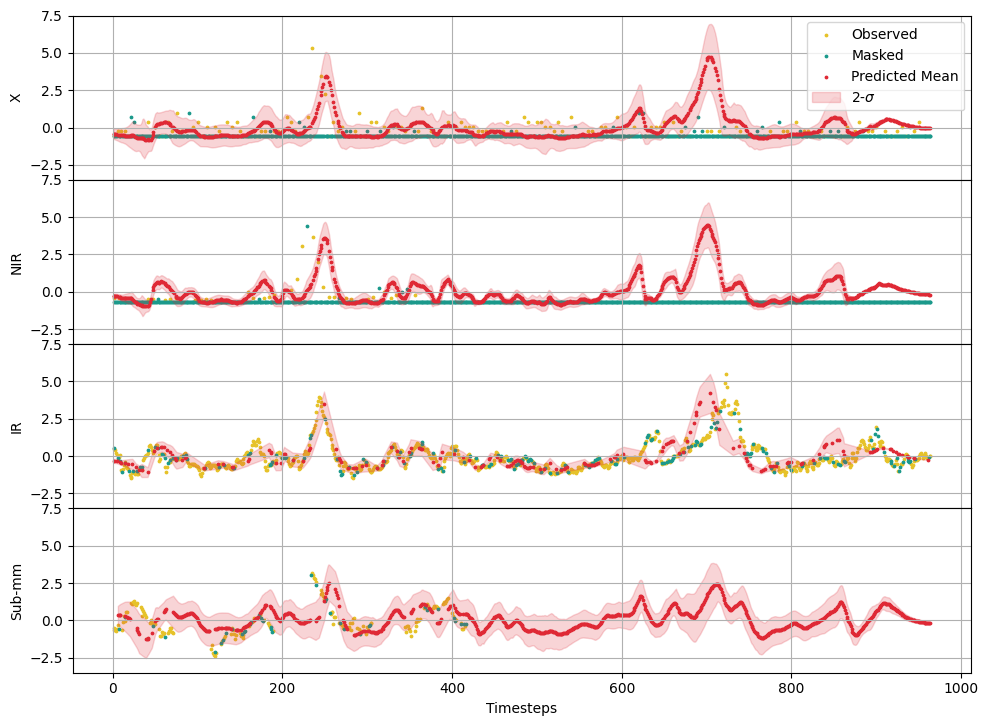

In [3]:
import argparse
import numpy as np
import torch
import models
import utils
import matplotlib.pyplot as plt

def plot_tripletformer_on_real_data(real_data, keys, model_path, save_path="coverage_test.npz"):
    """
    Evaluates the Tripletformer model on real data and saves the results.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dim = len(keys)

    # Create a dummy argparse namespace to load the model
    class DummyArgs:
        def __init__(self):
            self.dataset = 'sgra'  # Assuming 'sgra' dataset configuration
            self.experiment_id = model_path.split('_')[-1].split('.')[0]
            self.net = 'triple'
            self.imab_dim = 128
            self.cab_dim = 256
            self.decoder_dim = 128
            self.nlayers = 1
            self.enc_num_heads = 4
            self.dec_num_heads = 4
            self.num_ref_points = 128 #added this line
            self.mse_weight = 1.0 #added this line
            self.norm = True #added this line
            self.sample_tp = 0.1 #added this line
            self.sample_type = 'random' #added this line

    args = DummyArgs()

    net = models.load_network(args, dim, device=device).to(device)
    chp = torch.load(model_path, map_location=device)  # Load the model
    net.load_state_dict(chp['state_dict'])

    net.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        real_data_tensor = torch.tensor(real_data, dtype=torch.float32).to(device)

        # Create context and reconstruction masks
        original_mask = torch.ones(real_data_tensor[:, :, dim:2 * dim].shape).to(device)
        subsampled_mask = real_data_tensor[:, :, dim:2 * dim]
        recon_mask = original_mask - subsampled_mask
        context_y = torch.cat((real_data_tensor[:, :, :dim] * subsampled_mask, subsampled_mask), -1)

        # Compute predictions
        px, time_indices, channel_indices = net.inference(
            real_data_tensor[:, :, -1],  # Time progression indicator
            context_y,
            real_data_tensor[:, :, -1],
            torch.cat((real_data_tensor[:, :, :dim] * recon_mask, recon_mask), -1)
        )

        means = px.mean
        logvars = px.logvar
        std = torch.sqrt(torch.exp(logvars))

        # Move everything to CPU for processing
        means = means.squeeze().cpu().numpy()
        stds = std.squeeze().cpu().numpy()
        time_indices = time_indices.squeeze().cpu().numpy()
        channel_indices = channel_indices.squeeze().cpu().numpy()
        real_data_numpy = real_data_tensor[:, :, :-1].squeeze().cpu().numpy()

        # Save data
        saved_data = {}

        # Create subplots
        fig, axs = plt.subplots(dim, 1, figsize=(10, 2 * dim), sharex=True, gridspec_kw={'hspace': 0})
        timesteps = np.arange(1, real_data_numpy.shape[0] + 1)

        if dim == 1:
            axs = [axs]

        for chan in range(dim):
            ax = axs[chan]

            # Observed values
            obs_indices = np.where(real_data_numpy[:, chan + dim] == 1)
            obs_x = timesteps[obs_indices]
            obs_y = real_data_numpy[:, chan][obs_indices]

            # Masked values
            masked_indices = np.where(real_data_numpy[:, chan + dim] == 0)
            masked_x = timesteps[masked_indices]
            masked_y = real_data_numpy[:, chan][masked_indices]

            # Predictions
            pred_indices = np.where(channel_indices == chan)
            pred_times = time_indices[pred_indices]
            pred_means = means[pred_indices]
            pred_stds = stds[pred_indices]
            pred_lower = pred_means - 2 * pred_stds
            pred_upper = pred_means + 2 * pred_stds

            # Save arrays
            key_label = keys[chan] if keys else f"Channel_{chan+1}"
            saved_data[f"{key_label}_train_x"] = obs_x
            saved_data[f"{key_label}_train_y"] = obs_y
            saved_data[f"{key_label}_test_x"] = masked_x
            saved_data[f"{key_label}_test_y"] = masked_y
            saved_data[f"{key_label}_predicted_means"] = pred_means
            saved_data[f"{key_label}_lower_bound"] = pred_lower
            saved_data[f"{key_label}_upper_bound"] = pred_upper

            # Plot
            ax.scatter(obs_x, obs_y, s=3, color='#E6C229', label='Observed')
            ax.scatter(masked_x, masked_y, s=3, color='#1B998B', label='Masked')
            ax.scatter(pred_times, pred_means, linewidth=1, color='#DF2935', label='Predicted Mean', s=3)
            ax.fill_between(pred_times, pred_lower, pred_upper, alpha=0.2, color='#DF2935', label=r'2-$\sigma$')

            # Compute and print MSE
            tmp_mse = np.mean((masked_y - pred_means) ** 2)
            print(f'MSE for key {key_label} is: {tmp_mse:.5f}')

            # Labels
            ax.set_ylabel(key_label)
            ax.set_ylim(-3.5, 7.5)
            if chan == 0:
                ax.legend(loc="upper right")
            ax.grid(True)

        axs[-1].set_xlabel("Timesteps")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('figures/tripletformer_coverage.png')

        # Save the results
        np.savez(save_path, **saved_data)
        print(f"Results saved to {save_path}")

# Example Usage
real_data = np.load('../Analysis/coverage_test_data.npz')['real_data']
plot_tripletformer_on_real_data(real_data, ["X", 'NIR', 'IR', 'Sub-mm'], "./saved_models/best_model_sgra_final.h5")

/tmp/ipykernel_36911/4163401689.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chp = torch.load(model_path, map_location=device)  # Load the model


MSE for key X is: 1.26261
MSE for key NIR is: 1.43337
MSE for key IR is: 0.68787
MSE for key Sub-mm is: 398.18726
Results saved to coverage_test.npz


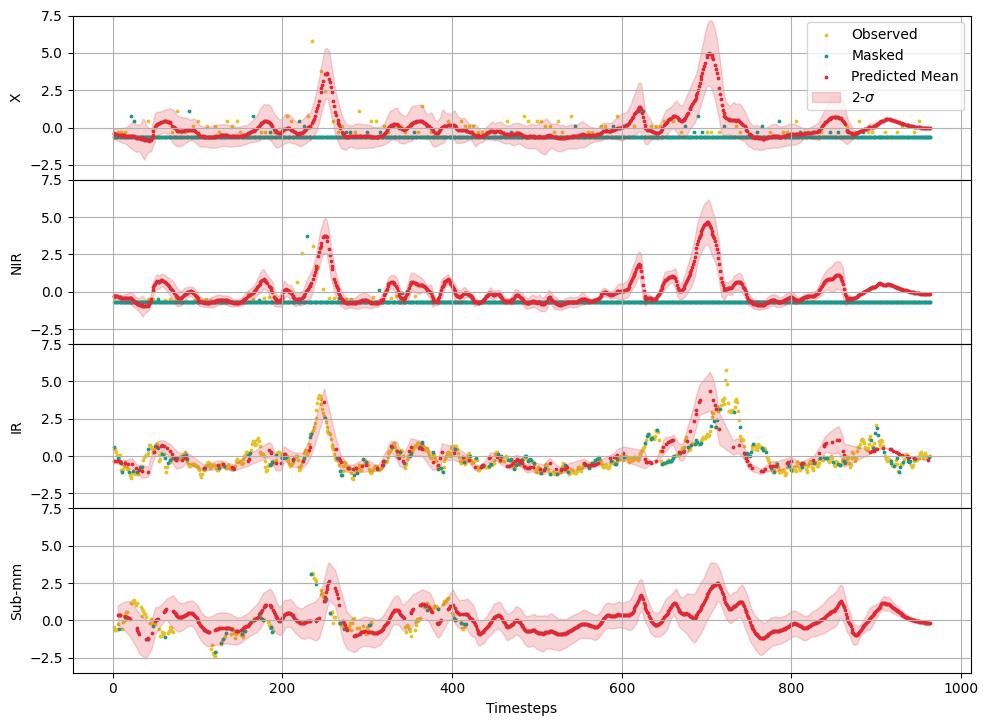

In [1]:
import argparse
import numpy as np
import torch
import models
import utils
import matplotlib.pyplot as plt

def plot_tripletformer_on_real_data(real_data, keys, model_path, save_path="coverage_test.npz"):
    """
    Evaluates the Tripletformer model on real data and saves the results.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dim = len(keys)

    # Create a dummy argparse namespace to load the model
    class DummyArgs:
        def __init__(self):
            self.dataset = 'sgra'  # Assuming 'sgra' dataset configuration
            self.experiment_id = model_path.split('_')[-1].split('.')[0]
            self.net = 'triple'
            self.imab_dim = 128
            self.cab_dim = 256
            self.decoder_dim = 128
            self.nlayers = 1
            self.enc_num_heads = 4
            self.dec_num_heads = 4
            self.num_ref_points = 128 #added this line
            self.mse_weight = 1.0 #added this line
            self.norm = True #added this line
            self.sample_tp = 0.1 #added this line
            self.sample_type = 'random' #added this line

    args = DummyArgs()

    net = models.load_network(args, dim, device=device).to(device)
    chp = torch.load(model_path, map_location=device)  # Load the model
    net.load_state_dict(chp['state_dict'])

    net.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        real_data_tensor = torch.tensor(real_data, dtype=torch.float32).to(device)

        # Create context and reconstruction masks
        original_mask = torch.ones(real_data_tensor[:, :, dim:2 * dim].shape).to(device)
        subsampled_mask = real_data_tensor[:, :, dim:2 * dim]
        recon_mask = original_mask - subsampled_mask
        context_y = torch.cat((real_data_tensor[:, :, :dim] * subsampled_mask, subsampled_mask), -1)

        # Compute predictions
        px, time_indices, channel_indices = net.inference(
            real_data_tensor[:, :, -1],  # Time progression indicator
            context_y,
            real_data_tensor[:, :, -1],
            torch.cat((real_data_tensor[:, :, :dim] * recon_mask, recon_mask), -1)
        )

        means = px.mean
        logvars = px.logvar
        std = torch.sqrt(torch.exp(logvars))

        # Move everything to CPU for processing
        means = means.squeeze().cpu().numpy()
        stds = std.squeeze().cpu().numpy()
        time_indices = time_indices.squeeze().cpu().numpy()
        channel_indices = channel_indices.squeeze().cpu().numpy()
        real_data_numpy = real_data_tensor[:, :, :-1].squeeze().cpu().numpy()

        # Save data
        saved_data = {}

        # Create subplots
        fig, axs = plt.subplots(dim, 1, figsize=(10, 2 * dim), sharex=True, gridspec_kw={'hspace': 0})
        timesteps = np.arange(1, real_data_numpy.shape[0] + 1)

        if dim == 1:
            axs = [axs]

        for chan in range(dim):
            ax = axs[chan]

            # Observed values
            obs_indices = np.where(real_data_numpy[:, chan + dim] == 1)
            obs_x = timesteps[obs_indices]
            obs_y = real_data_numpy[:, chan][obs_indices]

            # Masked values
            masked_indices = np.where(real_data_numpy[:, chan + dim] == 0)
            masked_x = timesteps[masked_indices]
            masked_y = real_data_numpy[:, chan][masked_indices]

            # Predictions
            pred_indices = np.where(channel_indices == chan)
            pred_times = time_indices[pred_indices]
            pred_means = means[pred_indices]
            pred_stds = stds[pred_indices]
            pred_lower = pred_means - 2 * pred_stds
            pred_upper = pred_means + 2 * pred_stds

            # Save arrays
            key_label = keys[chan] if keys else f"Channel_{chan+1}"
            saved_data[f"{key_label}_train_x"] = obs_x
            saved_data[f"{key_label}_train_y"] = obs_y
            saved_data[f"{key_label}_test_x"] = masked_x
            saved_data[f"{key_label}_test_y"] = masked_y
            saved_data[f"{key_label}_predicted_means"] = pred_means
            saved_data[f"{key_label}_lower_bound"] = pred_lower
            saved_data[f"{key_label}_upper_bound"] = pred_upper

            # Plot
            ax.scatter(obs_x, obs_y, s=3, color='#E6C229', label='Observed')
            ax.scatter(masked_x, masked_y, s=3, color='#1B998B', label='Masked')
            ax.scatter(pred_times, pred_means, linewidth=1, color='#DF2935', label='Predicted Mean', s=3)
            ax.fill_between(pred_times, pred_lower, pred_upper, alpha=0.2, color='#DF2935', label=r'2-$\sigma$')

            # Compute and print MSE
            tmp_mse = np.mean((masked_y - pred_means) ** 2)
            print(f'MSE for key {key_label} is: {tmp_mse:.5f}')

            # Labels
            ax.set_ylabel(key_label)
            ax.set_ylim(-3.5, 7.5)
            if chan == 0:
                ax.legend(loc="upper right")
            ax.grid(True)

        axs[-1].set_xlabel("Timesteps")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('figures/tripletformer_coverage.png')

        # Save the results
        np.savez(save_path, **saved_data)
        print(f"Results saved to {save_path}")

# Example Usage
real_data = np.load('../Analysis/coverage_test_data.npz')['real_data']
plot_tripletformer_on_real_data(real_data, ["X", 'NIR', 'IR', 'Sub-mm'], "./saved_models/best_model_sgra_final.h5")

# Noise Analysis with Noise Specific Trained Models

## 10% Noise

In [2]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_10 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 1152591

evaluate.py --niters 1 --batch-size 20 --dataset noise_10 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 1152591
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

## 30% Noise

In [3]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_30 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 6751105

evaluate.py --niters 1 --batch-size 20 --dataset noise_30 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 6751105
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

## 50% Noise

In [4]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_50 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 6243185

evaluate.py --niters 1 --batch-size 20 --dataset noise_50 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 6243185
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

## 70% Noise

In [5]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_70 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 5022442

evaluate.py --niters 1 --batch-size 20 --dataset noise_70 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 5022442
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

## 90% Noise

In [6]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_90 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 2592987

evaluate.py --niters 1 --batch-size 20 --dataset noise_90 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 2592987
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

## 95% Noise

In [7]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_95 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 9346663

evaluate.py --niters 1 --batch-size 20 --dataset noise_95 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --experiment-id 9346663
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

# Noise Analysis with Final Model

## 10% Noise

In [9]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_10 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5

evaluate.py --niters 1 --batch-size 20 --dataset noise_10 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

## 30% Noise

In [16]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_30 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5

evaluate.py --niters 1 --batch-size 20 --dataset noise_30 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

## 50% Noise

In [15]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_50 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5

evaluate.py --niters 1 --batch-size 20 --dataset noise_50 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

## 70% Noise

In [12]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_70 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5

evaluate.py --niters 1 --batch-size 20 --dataset noise_70 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

## 90% Noise

In [13]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_90 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5

evaluate.py --niters 1 --batch-size 20 --dataset noise_90 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

## 95% Noise

In [14]:
!python evaluate.py --niters 1 --batch-size 20 --dataset noise_95 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5

evaluate.py --niters 1 --batch-size 20 --dataset noise_95 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_final.h5
(9810, 1440, 9) (4905, 1440, 9) (1635, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

# Ablation Study - Number of Data Samples

## 500 Samples

In [1]:
!python evaluate.py --niters 1 --batch-size 20 --dataset sgra_500 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_500_3451345.h5

evaluate.py --niters 1 --batch-size 20 --dataset sgra_500 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_500_3451345.h5
(300, 1440, 9) (150, 1440, 9) (50, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have 

## 1000 Samples

In [2]:
!python evaluate.py --niters 1 --batch-size 20 --dataset sgra_1000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_1000_7106457.h5

evaluate.py --niters 1 --batch-size 20 --dataset sgra_1000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_1000_7106457.h5
(600, 1440, 9) (300, 1440, 9) (100, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't ha

## 5000 Samples

In [3]:
!python evaluate.py --niters 1 --batch-size 20 --dataset sgra_5000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_5000_7061637.h5

evaluate.py --niters 1 --batch-size 20 --dataset sgra_5000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_5000_7061637.h5
(3000, 1440, 9) (1500, 1440, 9) (500, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't 

## 10000 Samples

In [4]:
!python evaluate.py --niters 1 --batch-size 20 --dataset sgra_10000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_10000_68592.h5

evaluate.py --niters 1 --batch-size 20 --dataset sgra_10000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_10000_68592.h5
(6000, 1440, 9) (3000, 1440, 9) (1000, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't

## 14000 Samples

In [5]:
!python evaluate.py --niters 1 --batch-size 20 --dataset sgra_14000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_14000_4332034.h5

evaluate.py --niters 1 --batch-size 20 --dataset sgra_14000 --norm --shuffle --imab-dim 128 --cab-dim 256 --decoder-dim 128 --num-ref-points 128 --modelpath best_model_sgra_14000_4332034.h5
(8400, 1440, 9) (4200, 1440, 9) (1400, 1440, 9)
evaluate.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don